## 0 - Imports

In [ ]:
%load_ext autoreload
%autoreload

In [207]:
import scipy.io as spio
import pandas as pd
import numpy as np
from numpy import absolute as nabs
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LassoCV
#from sklearn.metrics import mean_squared_error
from numpy.linalg import LinAlgError
from datetime import datetime

## 1 - Load, clean, test data

In [184]:
def impmat(fname = 'M_processed.mat', writ = True):
    ''' import matlab crap, and turn it to pickles (or return panda df)'''
    mat = spio.loadmat(fname, squeeze_me=True)
    M = mat['M'] 
    head = ['time','ndc1','ndc2','ndc3',
            'Trade_Partner_Name', 'Distribution_Center_State','NDC','Distribution_Center_ID_(IC)',
    'Distribution_Center_Zip','Eff_Inv_(EU)','Eff_Inv_(PU)','Qty_Ord_(EU)',
            'Qty_Ord_(PU)']
    # get rid of ndc 1,2,3 because they're pieces of NCD
    # also get rid of purchase units, just use eatable
    # also get rid of states and zip code
    needed = [0,4,6,7,9,11]
    head_adj = [head[i] for i in needed] + ["year", "month", "week"]
    data = pd.DataFrame(M, columns=head)
    data["time"] = pd.to_datetime(data.time, format='%Y%m%d', errors='coerce')
    data["year"] = data.time.dt.year
    data["month"] = data.time.dt.month
    data["week"] = data.time.dt.week
    #data.drop("time", axis=1)
    if writ: # h5 allows your variable to be external
        dt = pd.HDFStore("drugdata.h5") # don't need to import/export! warning, though: huge
        dt['dat'] = data[head_adj] #
    return(data)

In [2]:
def test_hd5(p = 0, q = 0):
    """test data and run answers to intro quiz
    p is to print head of dataframe
    q prints quiz answers
    doesn't return anything
    mostly for access examples"""
    dt = pd.HDFStore("drugdata.h5")["dat"]

    header = dt.columns.tolist()
    # thanks @brock
    def q1(df):
        return(df.Trade_Partner_Name.unique())
    
    def q2(df):
        q2 = df.groupby('Trade_Partner_Name')['Distribution_Center_ID_(IC)'].nunique()
        q2max = q2.max()
        return(q2[q2 == q2max])
    
    def q3(df):
        q3df = df.loc[df["time"].dt.year == 2011] # can also use dt.month
        q3TotalSales = q3df.groupby('NDC')['Qty_Ord_(EU)'].sum()
        #print(q3TotalSales)
        q3sorted = q3TotalSales.sort_values(ascending = False).head()
        return(q3sorted)
    
    def q4(df):
        q4 = df['NDC'].value_counts()
        NDCLessThan60 = q4[q4 < 60]
        if (NDCLessThan60.size == 0):
            return(None)
        else:
            return(NDCLessThan60.size)
        
    def q5(df):
        q5 =  df.groupby('NDC')['Qty_Ord_(EU)'].std()
        q5max = q5.max()
        NDCHighestVariance = q5[q5 == q5max]
        return(NDCHighestVariance)
    
    def q6(df):
        q6 = df.groupby('NDC')['Qty_Ord_(EU)'].nunique()
        q6ZeroDemand = q6[q6 == 0]
        if (q6ZeroDemand.size == 0):
            return(None)
        else:
            return(q6ZeroDemand.size)
    
    if p:
        for col in header:
            print(dt[col].head())
    if q:
        answers = [q1(dt), q2(dt), q3(dt), q4(dt), q5(dt), q6(dt)]
        for i, ans in enumerate(answers):
            try:
                print('Question %d'%(i+1),  ans)
            except:
                print('Question %d'%(i+1) + str(ans))

In [185]:
#impmat(); # uncomment if never built h5 file
#test_hd5(q=1) # add p=1 or q = 1 to print stuff

In [242]:
def rem_neg_vals():
    ''' if you've just imported from the mat file,
    you need to run this to change the neg vals to 0 '''
    df = pd.HDFStore("drugdata.h5")["dat"]
    # set negative values to 0
    df.loc[df['Eff_Inv_(EU)'] < 0,'Eff_Inv_(EU)'] = 0
    df.loc[df['Qty_Ord_(EU)'] < 0,'Qty_Ord_(EU)'] = 0
    df.loc[df['Eff_Inv_(EU)'].isnull(), 'Eff_Inv_(EU)'] = 0
    df.loc[df['Qty_Ord_(EU)'].isnull(), 'Qty_Ord_(EU)'] = 0
    #print(df.head())
    return(True)

In [187]:
rem_neg_vals();

## 2 - Early queries

In [9]:
def weeks():
    ''' gives us a list of the weeks as a datetime Series '''
    df = pd.HDFStore("drugdata.h5")["dat"]

    return(pd.to_datetime(df.time.unique()).sort_values())

In [18]:
weeks();

In [10]:
def sales_exist():
    ''' want to check that every week has sales
        returns list of drug ids that have data for every year '''
    df = pd.HDFStore("drugdata.h5")["dat"]
    useless = {}
    years = [i for i in range(2007, 2018)]
    for drug in df.NDC.unique():
        useless[drug] = []
    for year in years:
        sales = df.loc[df.time.dt.year == year].groupby('NDC')['Qty_Ord_(EU)'].sum()
        for drug in df.NDC.unique():
            try:
                if sales[drug] == 0:
                    #print(drug, year) # have 0 sum
                    useless[drug].append(year)
            except:
                #print("broke by", drug, "in", year)
                useless[drug].append(year) # have NA or something?
    not_useless = []
    for did in useless.keys():
        if not useless[did]:
            not_useless.append(did)
    return(not_useless)

In [142]:
sales_exist();

In [11]:
def top_selling(thr, p = 0):
    ''' in: minimum contributing percentage threshold
        if p, prints number and % of drugs above thr
        out: IDs of drugs above thr'''
    df = pd.HDFStore("drugdata.h5")["dat"]
    ind_total = df.groupby('NDC')['Qty_Ord_(EU)'].sum()
    sortsales = ind_total.sort_values(ascending = False)
    #print(sortsales)
    total = sum(ind_total.values)
    perc_total = 100 * sortsales / total
    clipped_above_total = perc_total[perc_total > thr]
    if p:
        print(len(clipped_above_total), sum(clipped_above_total.values))
    enough = sales_exist()
    final = [i for i in enough if i in clipped_above_total.axes[0]]
    #return(clipped_above_total.axes)
    return(final)

In [243]:
top_selling(1.5)

[154.0, 145.0, 4.0, 7.0, 141.0, 149.0, 32.0, 55.0, 8.0, 125.0]

In [180]:
def norm_drugs(writ = 0):
    ''' returns the data frame with only top ten drugs
        and has normed column where ordered EU is normalized with (val-mu)/sigma 
        writ = 'normed' -> h5 '''
    dl = top_selling(1.5)
    df = pd.HDFStore("drugdata.h5")["dat"]
    df.set_index("NDC", inplace=True) # use drug as index
    df = df.loc[dl] # only want drugs in top ten
    dfgb = df.groupby('NDC')['Qty_Ord_(EU)']
    sd = dfgb.std() # standard deviation for each drug
    nm = dfgb.mean() # mean for each drug

    normd = pd.DataFrame() # empty DF to hold new one
    # couldn't figure out vector without using all the memory :/
    for drug in dl:
        d_s = df.loc[drug,:] # select only one drug for now
        n_s = np.subtract(d_s["Qty_Ord_(EU)"],nm[drug]) # numerator
        
        n_v = d_s.assign(normed=np.divide(n_s, sd[drug])) # new df for drug
        normd = pd.concat([normd, n_v]) # add to return df
        
    if writ: # should we write this to h5?
        df_n = pd.HDFStore("drugdata.h5")
        df_n["normed"] = normd
    return(normd)

In [189]:
#ndf = norm_drugs(1)
#print(ndf.head)

In [70]:
def helper():
    ''' useless function to test random stuff '''
    df = pd.HDFStore("drugdata.h5")["dat"]
    
    print(df.columns.values)

    print(df["week"])
#helper()

## 3 - The meaty bits!

In [66]:
def sales(Year):
    """in: range of dates want studied 
    want to return the list of sales per date
    todo: break up by location if we want"""
    df = pd.HDFStore("drugdata.h5")["dat"]
    
    sel_drugs = top_selling(1.5) # list of drug ids
    dates = df.loc[df.year == Year] # choose only given year
    # gives DF of drugs by week; can change to 
    # ['NDC', 'time', DISTRO_id] if we want later
    window = dates.groupby(['NDC', 'year', 'week'])['Qty_Ord_(EU)'].sum()
    filt_window = window.loc[sel_drugs] # only want top drugs
    return(filt_window)

In [67]:
sales(2008);

In [14]:
def smape(f, d):
    ''' symmetric mean absolute percentage error
    in: vectors f = y_hat, d = y 
    out: the smape, yo '''
    n = len(f)
    num = np.sum(nabs(f - d))
    denom = np.sum(nabs(f) + nabs(d))
    return((1/n) * num/denom)

In [15]:
def frame_gen(year):
    ''' in: the year starting the frame
        out: 2 dfs, 3 years for training and 4th for test'''
    window = []
    for i in range(4): #3? switched to match AR model
        window.append(sales(year + i))
    # make a table of 3 years
    window = pd.concat(window)
    #test_frame = sales(year + 3)
    return(window)#, test_frame)

In [30]:
def svr_try_0(tst, trn):
    ''' input: testing and training data 
        out: support vector regression score(?) '''
    
    from sklearn_pandas import DataFrameMapper, cross_val_score
    
    
  #  mapper = DataFrameMapper([('week', le)
                             
   #                          ])
    le = pp.LabelEncoder()
    #lb = pp.LabelBinerizer()
    y = le.fit_transform(y)
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    print(len(x_train))
    
    with open("out.txt", "w") as f:
        for i in range(-2, 2):
            svm = SVR(kernel="poly", C=10**i, random_state=0)
            svm.fit(x_train, y_train)
            f.write("c = " + str(10**i) + ", accuracy = " + 
            str(round(svm.score(x_test, y_test), 3)) + "\n")

In [267]:
def plot_drug_sales():
    df = pd.HDFStore("drugdata.h5")['normed']
    dl = top_selling(1.5)
    
    for drug in dl:
        sub = df.loc[drug]
        ndcSales = sub.groupby("time")["Qty_Ord_(EU)"].sum()
        fig, ax = plt.subplots()
        ax.plot(ndcSales, 'bo')
        ax.set(xlabel='Year', ylabel='Extended Units',
           title='Total Sales drug ' + str(drug))
        ax.grid()
        plt.show()
        
#plot_drug_sales()

In [ ]:
def ARIMA_stuff(tst, trn):
    
    df = pd.HDFStore("drugdata.h5")['dat']
    #print(df['time'])
    # want to generalize
    #NDC = 4 has the highest total sales
    ndc4 = df.loc[df["NDC"]==4]
    
    ndc4TotalSales = ndc4.groupby('time')['Qty_Ord_(EU)'].sum()

    ndc4Times = ndc4.time.unique()

    ndc4Times = np.array(ndc4Times)
    ndc4Times.sort()

    ndc4TotalSales = np.array(ndc4TotalSales)


    autocorrelation_plot(ndc4TotalSales)
    plt.show()
    #print(X)
    #d = {'times': ndc4Times, 'sales': ndc4TotalSales}
    df2 = pd.DataFrame(index=ndc4Times, data=ndc4TotalSales, columns=['sales'])
    #print(df2)

    df2.plot()
    plt.show()

    dftest = pd.DataFrame(index=ndc4Times[400:], data=ndc4TotalSales[400:], columns=['sales'])


    ########ARIMA#############

    autocorrelation_plot(dftest)
    plt.show()

    model = ARIMA(dftest, order=(10,1,0))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())

    X = dftest.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    print("Train/test split")
    history = [x for x in train]
    predictions = list()
    print("About to FOR loop")
    for t in range(len(test)):
        model = ARIMA(history, order=(10,1,0))
        try: model_fit = model.fit(disp=0)
        except (ValueError, LinAlgError): pass
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    print("Out of FOR loop")
    error = smape(test, predictions)
    print('Test sMAPE: %.3f' % error)
    # plot
    fig, ax = plt.subplots()
    ax.plot(test)
    ax.plot(predictions, color='red')
    ax.set(xlabel='time (wk)', ylabel='Extended Units',
       title='Predicted vs Actual ARIMA')
    ax.grid()

    plt.show()



time
2007-07-01    33600.0
2007-07-08    33600.0
2007-07-15        0.0
2007-07-22        0.0
2007-07-29        0.0
2007-08-05        0.0
2007-08-12        0.0
2007-08-19        0.0
2007-08-26    31200.0
2007-09-02        0.0
Name: Qty_Ord_(EU), dtype: float64


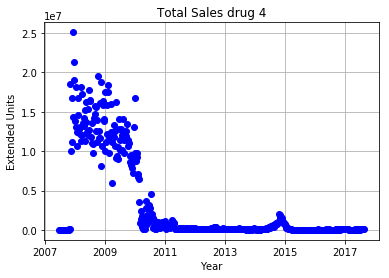

['2007-07-01T00:00:00.000000000' '2007-07-08T00:00:00.000000000'
 '2007-07-15T00:00:00.000000000' '2007-07-22T00:00:00.000000000'
 '2007-07-29T00:00:00.000000000' '2007-08-05T00:00:00.000000000'
 '2007-08-12T00:00:00.000000000' '2007-08-19T00:00:00.000000000'
 '2007-08-26T00:00:00.000000000' '2007-09-02T00:00:00.000000000']


In [261]:
ARIMA_stuff(1, 2)

In [27]:
def NN_stuff(tst, trn):
    ''' All you, Collin '''
    pass

In [28]:
def lasso_stuff(tst, trn):
    
    df = pd.HDFStore("drugdata.h5")['dat']

    # want to generalize
    #NDC = 4 has the highest total sales
    ndc4 = df.loc[df["NDC"]==4]
    
    ndc4TotalSales = ndc4.groupby('time')['Qty_Ord_(EU)'].sum()

    ndc4Times = ndc4.time.unique()

    ndc4Times = np.array(ndc4Times)
    ndc4Times.sort()

    ndc4TotalSales = np.array(ndc4TotalSales)


    df2 = pd.DataFrame(index=ndc4Times, data=ndc4TotalSales, columns=['sales'])

    
    dftest = pd.DataFrame(index=ndc4Times[400:], data=ndc4TotalSales[400:], columns=['sales'])

    X = ndc4Times
    Y1 = ndc4TotalSales
    
    start = time.time()
    
    a=10
    #print(a)
    Y_past = [ Y1 ]
    for i in range(a):
        Yi = Y_past[len(Y_past)-1]
        Yi = np.insert(Yi, 0, 0)
        Y_past.append(Yi[0:len(Y1)])
    Y_past = np.matrix(Y_past)
    #Y_past = np.transpose(Y_past)
    #print(Y1)
    #print("Y: ")
    #print(Y_past)
    
    #print("Y shape: ")
    #print(Y_past.shape)
    
    Y_past = np.delete(Y_past, 0, 0)
    #print("Y: ")
    #print(Y_past)
    Y = Y1
    #print("New shape of Y_past: ")
    Y_past = np.transpose(Y_past)
    #print(Y_past.shape)
    

    #print(X[0])
    Xts = (X - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    #print(Xts[0])
    Xts = Xts.reshape(Xts.shape[0], 1)
    #print(Xts.shape)
    
    IN = np.hstack((Xts, Y_past))
    #print("Input matrix: ")
    #print(IN)
    print("Input Shape: ")
    print(IN.shape)
    
    
    
    
    size = int(IN.shape[0]*0.66)
    #print(size)
    #X_train, X_test = Xts[0:size], Xts[size: len(Xts)]
    X_train, X_test = IN[0:size,:], IN[size:IN.shape[0],:]
    #[X_train, X_test] = np.vsplit(IN, size) ################
    Y_train, Y_test = Y[0:size], Y[size: len(Y)]
    X_train_64, X_test_64 = X[0:size], X[size: len(X)]
    Y_train_64, Y_test_64 = Y[0:size], Y[size: len(Y)]
    
    
    #X_train = X_train.reshape(-1, 1)
    Y_train = Y_train.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)
    
    if p:
        print("X_train shape: ", X_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_train shape: ", Y_train.shape)
        print("Y_test shape: ", Y_test.shape)
        print("X_train type: ", X_train.dtype)
        print("X_test type: ", X_test.dtype)
        print("Y_train type: ", Y_train.dtype)
        print("Y_test type: ", Y_test.dtype)

    regr = LassoCV()
    regr.fit(X_train, Y_train)
    
    pred_trained = []
    pred = []
    for x1 in X_train:
        #if j==0:
         #   x1 = x1.reshape(-1,1)
        yHat_trained = regr.predict(x1)
        pred_trained.append(yHat_trained)
    for x in X_test:
        #if j==0:
         #   x = x.reshape(-1,1)
        yHat = regr.predict(x)
        pred.append(yHat)
        
    #X_convert = X_train.reshape(X_train.shape[0]) 
    X_convert = datetime.utcfromtimestamp(X_train[0,0])
    #X_test_64 = datetime.utcfromtimestamp(X_test)
    #Y_test_64 = datetime.utcfromtimestamp(Y_test)
    #pred_64 = datetime.utcfromtimestamp(pred)
    X_convert = np.datetime64(X_convert)
    #X_test_64 = np.datetime64(X_test)
    #Y_test_64 = np.datetime64(Y_test)
    #pred_64 = np.datetime64(pred)
    
    #print(X_convert)
    
    plt.plot(X_train_64, Y_train, color='green')
    plt.plot(X_train_64, pred_trained, color='red')
    plt.plot(X_test_64, pred, color='orange')
    plt.plot(X_test_64, Y_test, color='blue')
    plt.show()
    
    error = mean_squared_error(Y_test, pred)
    print("Error: ", error)
    #errors.append(error)
    
    
                    
    #plt.plot(J, errors, color='red')
    #plt.show()
    
    end = time.time()

In [163]:
def testing_setup():
    df = pd.HDFStore("drugdata.h5")["dat"]
    [trn, tst] = frame_gen(2008)
    dl = top_selling(1.5)
    for drug in dl:
        print(drug, trn[drug])

## Plots

In [190]:
def Auto_regress(drug, X, lag_size, plots=0):
    ''' need model for each drug id; maybe pass in main?
        test data, train data
        lag is number of previous vars
        but, model chooses lag size?? '''
    # sauce: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
    #from sklearn.svm import SVR
    from statsmodels.tsa.ar_model import AR
    
    # at this point all drugs have all data for all years, so we can generalize
    X_trn = X[drug].values[:157] # first 3 years
    X_tst = X[drug].values[157:] # next
    if plots:
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(X_trn, lags=lag_size)
        plt.show()
    model = AR(X_trn)
    fits = model.fit()
    print("Thetas:", fits.params)
    print("lag:", fits.k_ar)
    
    pred = fits.predict(start=len(X_trn), end=len(X_trn)+len(X_tst)-1, dynamic=True)
    from sklearn.metrics import mean_squared_error as mse
    print("MSE:", mse(X_tst, pred))
    plt.plot(X_tst)
    plt.plot(pred, color='red')
    plt.show()

In [191]:
def main(lag_size):
    dt = pd.HDFStore("drugdata.h5")["dat"]
    # we are gonna add 3 to this. only want full years too, why not.
    spread = [i for i in range(2008, 2013)]
    dlist = top_selling(1.5)
    
    thetaset = np.zeros(shape=(len(dlist), lag_size))# what do we want here???
    thetaset = pd.DataFrame(thetaset, index=dlist)
    for year in spread: # sliding window for analysis
        X = frame_gen(year)
        for drug in dlist:
            Auto_regress(drug,X,lag_size)
        return(0)
#         seth = svr_stuff(tst, trn)
#         collin = nn_stuff(tst, trn)
#         jack = ARIMA(tst, trn)
#         maybe = lasso_stuff(tst, trn)
#         which = [seth, collin, jack, maybe]
#         who = ["seth", "collin", "jack", "maybe"]
#         best_for_year = who[which.index(min(which))]
#         print("The best for", year, "is", best_for_year)
        
    

In [189]:
main(10)

Thetas: [ -2.53151887e+05   2.66899306e-01   2.87649176e-01   1.09347682e-01
   7.83628909e-02   2.56090739e-01  -7.19345227e-02  -1.89046394e-01
   2.05497932e-01  -4.30616389e-02   8.47304849e-02  -1.55375569e-01
   2.83222764e-02   1.31231028e-01]
lag: 13
MSE: 3.21873256852e+12
Thetas: [  2.37873932e+05   3.20859404e-01   2.69673384e-01   5.76518303e-02
   1.40373714e-01   1.34357687e-01  -8.22844634e-02  -8.92731745e-02
   6.59051487e-02   4.72977527e-02  -9.38356295e-02   4.40095060e-02
  -6.46077536e-02   2.52229486e-02]
lag: 13
MSE: 151229615977.0
Thetas: [ -3.50372707e+04   1.03009834e-01   2.35838907e-02   2.18393791e-01
   9.28332923e-02   2.27667419e-01   1.12834534e-01  -6.87576875e-02
   1.07012636e-01   3.19997227e-02   6.79399986e-02   2.56175693e-02
   2.64057308e-02   1.46675072e-02]
lag: 13
MSE: 32225542952.5
Thetas: [  5.04807334e+04   5.78984894e-02   4.80352043e-03   1.10902242e-01
   1.36516665e-01   2.03507154e-01   9.56274071e-02  -2.07606367e-02
  -9.14241318e-

0

In [ ]:
cors: [5, 6, 0, 6, 5, 0, 5, 6, 6, 8]